In [3]:
import glob
import os
import re

from io import open

import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk import tokenize
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
# import matplotlib as mpl


%matplotlib inline

## Feature extraction

In [ ]:
jeff.withdraw(100.0) is just shorthand for Customer.withdraw(jeff, 100.0),

In [4]:
class TextPrep(object):
    def __init__(self, local_dir):
        self.local_dir = local_dir
        self.files = glob.glob(self.local_dir + 'text/*.txt')


    def summary_list(self):
        summary_list = []
        for doc_name in self.files:
            with open(doc_name, 'rt') as in_file:
                full_text = in_file.read()
                sentences_list = tokenize.sent_tokenize(full_text)
                summary_tag = re.compile('A BILL TO BE ENTITLED')
                summary_sentences = list(filter(summary_tag.search, sentences_list))
                for sentence in summary_sentences:
                    cleaned_sentence = \
                        re.sub('.*A BILL TO BE ENTITLED AN ACT relating to ', 
                                '', sentence)
            summary_list.append(cleaned_sentence)
        return summary_list
  
    
    def bill_name_list(self):
        bill_name_list = [doc_name.split('/')[-1].rstrip('.txt')
                          for doc_name in self.files]
        return bill_name_list


    def summary_dict(self):
        summary_dict = {}
        bill_summaries = list(zip(self.bill_name_list(), self.summary_list()))
        for bill, summary in bill_summaries:
            summary_dict[bill] = summary
        return summary_dict


    def tokenize_text(self, text):
        all_tokens = [word.lower()
                      for sent in tokenize.sent_tokenize(text)
                      for word in tokenize.word_tokenize(sent)]
        tokens = []
        for token in all_tokens:
            if re.search('[a-zA-Z]', token):
                tokens.append(token)
        return tokens
 

    def tokenize_and_stem(self, text):
        stemmer = SnowballStemmer('english')
        stems = [stemmer.stem(token) for token in self.tokenize_text(text)]
        return stems

        
        
    def build_vocab_df(self):
        vocab_stemmed = [words_stemmed
                         for summary in self.summary_list()
                         for words_stemmed in self.tokenize_and_stem(summary)]
        vocab_tokenized = [words_tokenized
                           for summary in self.summary_list()
                           for words_tokenized in self.tokenize_text(summary)]
        vocab_df = pd.DataFrame({'words': vocab_tokenized},
                                index = vocab_stemmed)
        return vocab_df
    
#     def vectorize(self, ?):
#         tfidf_vectorizer = TfidfVectorizer(max_df=.8, stop_words='english',
#                                  use_idf=True, tokenizer=tokenize_and_stem,)
#         return 

In [5]:
s = TextPrep('/Users/rhaggerty/remote/bills/tx/data/')
# vocab_tokenized = []
# for summary in s.summary_list():
#     words_tokenized = s.tokenize_text(summary)
#     vocab_tokenized.extend(words_tokenized)
# print(vocab_tokenized)

# s.build_vocab_df()
s.summary_dict()

{'HB00001E': 'avoiding the abolishment of certain agencies subject to the Texas Sunset Act on September 1, 2017.',
 'HB00001H': 'avoiding the abolishment of certain agencies subject to the Texas Sunset Act on September 1, 2017.',
 'HB00001I': 'avoiding the abolishment of certain agencies subject to the Texas Sunset Act on September 1, 2017.',
 'HB00002E': 'the repeal of certain riders for the Texas Medical Board and the Texas State Board of Examiners of Psychologists from the General Appropriations Act that are contingent upon the approval of certain Acts continuing those agencies during the 85th Regular Session.',
 'HB00002H': 'the repeal of certain riders for the Texas Medical Board and the Texas State Board of Examiners of Psychologists from the General Appropriations Act that are contingent upon the approval of certain Acts continuing those agencies during the 85th Regular Session.',
 'HB00002I': 'the funding of certain governmental entities subject to abolishment on September 1, 2

## Clustering

In [6]:
tfidf_vectorizer = TfidfVectorizer(max_df=.8, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem,)
full_summaries = summary_dict()
summary_list = list(full_summaries.values())
tfidf_matrix = tfidf_vectorizer.fit_transform(summary_list)
terms = tfidf_vectorizer.get_feature_names()
print(tfidf_matrix.shape)

NameError: name 'tokenize_and_stem' is not defined

In [1]:
terms = tfidf_vectorizer.get_feature_names()
terms

NameError: name 'tfidf_vectorizer' is not defined

In [37]:
num_clusters = 4

km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

#
joblib.dump(km,  'doc_cluster.pkl')
#
km = joblib.load('doc_cluster.pkl')

In [54]:
bills = {'names': names_list, 'synopsis': summary_list, 'cluster': clusters }
bills_df = pd.DataFrame(bills, index = [clusters] , columns = ['synopsis', 'cluster', 'names'])
bills_df['cluster'].value_counts()

0    230
2    105
1     91
3     78
Name: cluster, dtype: int64

In [68]:
print("Top terms per cluster:")

order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
for cluster in range(num_clusters):
    print("Cluster {}:".format(cluster))
    
    for ind in order_centroids[cluster, :10]: #replace 10 with n words per cluster
        print(' {}'.format(vocab_df.loc[terms[ind].split(' ')].values.tolist()[0][0]), end=',')
    print()

Top terms per cluster:
Cluster 0:
 certain, health, maternal, regulation, morbidity, groundwater, requirements, municipal, abortion, retirement,
Cluster 1:
 ad, valorem, ad, tax, appraised, valorem, homestead, residence, residence, authorizing,
Cluster 2:
 criminal, state, offense, government, criminal, creating, certain, creating, officers, penalty,
Cluster 3:
 school, public, public, finance, school, program, teacher, districts, appropriations, salary,


## Plotting

In [60]:
# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
dist = 1 - cosine_similarity(tfidf_matrix)

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}
cluster_names = {0: 'criminal, offense, penalty', 
                 1: 'tax, homestead', 
                 2: 'maternal, pregnancy-related, morbidity', 
                 3: 'school, finance, teacher', 
}

cluster_df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=names_list))
groups = cluster_df.groupby('label')

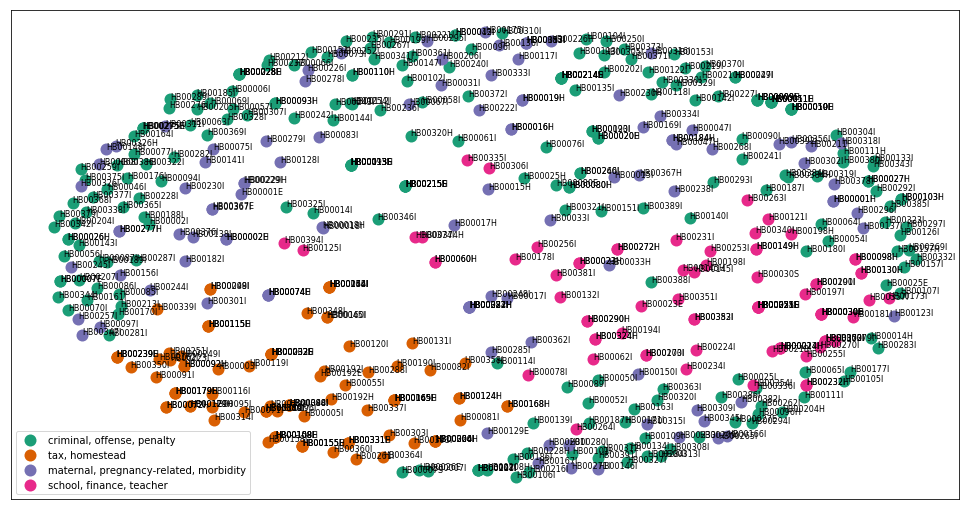

In [66]:
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)

#add label in x,y position with the label as the film title
for i in range(len(cluster_df)):
    ax.text(cluster_df.loc[i]['x'], cluster_df.loc[i]['y'], cluster_df.loc[i]['title'], size=8)  
    
plt.show()

#plt.savefig('clusters_small_noaxes.png', dpi=200)